In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# path = "/content/drive/MyDrive/Sentiment-Analysis-using-BERT-master/Sentiment-Analysis-using-BERT-master/Data/"

In [1]:
import pickle
import pandas as pd
df = pd.read_csv("train.csv")
df = df.dropna()

In [ ]:
# df = df.sample(n=1000, random_state=42)

In [2]:
data = df.review.to_list()
label = df.label.to_list()

In [ ]:
#!pip install -q keras-bert==0.85.0
#!pip install -q keras-rectified-adam

In [ ]:
!wget -q https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip -o multi_cased_L-12_H-768_A-12.zip

In [ ]:
#!pip install tensorflow-addons

In [ ]:
#from tensorflow_addons.optimizers import RAdam

In [ ]:
# Install the required libraries
!pip install -q keras-bert==0.88.0
!pip install -q keras-radam==0.2.0

# Download and extract the BERT model
!wget -q https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip -o multi_cased_L-12_H-768_A-12.zip

In [ ]:
# Install the required versions of TensorFlow and Keras
!pip install tensorflow==2.10.1
!pip install keras==2.10.0

In [3]:
import codecs
import tensorflow as tf
from tensorflow import keras
import os
from keras_radam import RAdam
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
import numpy as np

2024-04-15 01:41:20.429507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 01:41:20.682107: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 01:41:21.726044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-15 01:41:21.726088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missi

In [4]:
SEQ_LEN = 64  # Decrease sequence length
BATCH_SIZE = 64  # Increase batch size
EPOCHS = 5  # Decrease number of epochs
LR = 1e-5  # Decrease learning rate

pretrained_path = 'multi_cased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [5]:
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    trainable=True,
    seq_len=SEQ_LEN,
    output_layer_num=4
)

2024-04-15 01:41:25.374704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 01:41:32.577678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9639 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5
2024-04-15 01:41:32.579214: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9639 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5
2024-04-15 01:41:32.580525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/tas

In [6]:
token_dict = {}
with codecs.open(vocab_path, 'r', encoding='utf-8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

tokenizer = Tokenizer(token_dict, cased=False)  # Update based on the model

In [7]:
inputs = model.inputs[:2]
newout = model.output[:, 0, :]
newout = keras.layers.Dense(512, activation='relu')(newout)  # Update based on the model
outputs = keras.layers.Dense(units=1, activation='sigmoid')(newout)
model = keras.models.Model(inputs, outputs)

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=LR)

In [9]:
# Compile your model using the tf.keras optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
from sklearn.model_selection import train_test_split

def load_data(data, sentiments):
    global tokenizer
    indices = []
    for text in data:
        ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
        indices.append(ids)

    return [np.array(indices), np.zeros_like(indices)], np.array(sentiments)

data_train, data_valid, label_train, label_valid = train_test_split(data, label, test_size=0.15, random_state=48)
X_train, Y_train = load_data(data_train, label_train)
X_valid, Y_valid = load_data(data_valid, label_valid)

In [11]:
test = pd.read_csv('test.csv')
test = test.dropna()
#test = test.sample(n=1000, random_state=42)
data_test = test.review.tolist()
label_test = test.label.tolist()
X_test, Y_test = load_data(data_test, label_test)

In [12]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('256_checkpoint_data1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [13]:
model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=[X_valid, Y_valid], callbacks=callbacks_list)

y_pred = np.round(model.predict(X_test))

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Epoch 1/5
532/532 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.7391
Epoch 1: val_accuracy improved from -inf to 0.79117, saving model to 256_checkpoint_data1.h5
532/532 [==============================] - 282s 473ms/step - loss: 0.5050 - accuracy: 0.7391 - val_loss: 0.4364 - val_accuracy: 0.7912
Epoch 2/5
532/532 [==============================] - ETA: 0s - loss: 0.3849 - accuracy: 0.8194
Epoch 2: val_accuracy improved from 0.79117 to 0.81233, saving model to 256_checkpoint_data1.h5
532/532 [==============================] - 253s 475ms/step - loss: 0.3849 - accuracy: 0.8194 - val_loss: 0.4082 - val_accuracy: 0.8123
Epoch 3/5
532/532 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.8580
Epoch 3: val_accuracy did not improve from 0.81233
532/532 [==============================] - 195s 366ms/step - loss: 0.

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(Y_test, y_pred))
print(recall_score(Y_test, y_pred))
print(f1_score(Y_test, y_pred))

0.7960799095363739
0.8382615598333003
0.816626389560174


In [15]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8103


In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0, 1]
cn = confusion_matrix(Y_test, y_pred, labels=labels)

In [17]:
cn

array([[3879, 1082],
       [ 815, 4224]])

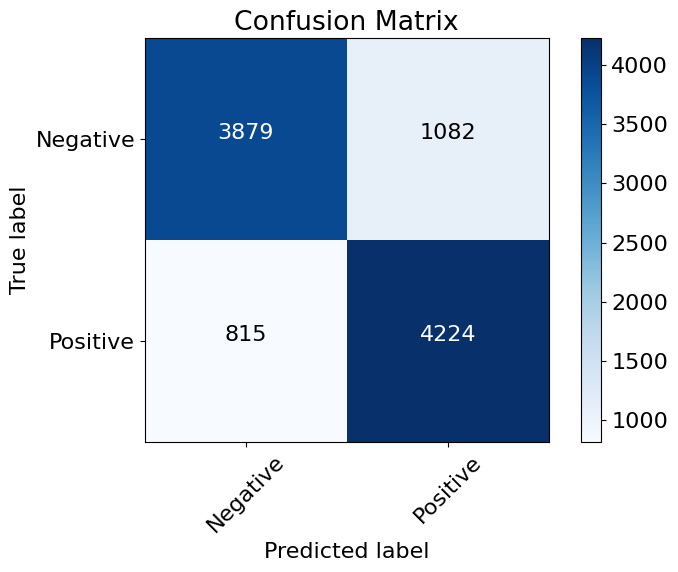

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cn = confusion_matrix(Y_test, y_pred)

# Define labels
labels = ['Negative', 'Positive']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cn, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Display numerical values within the plot
thresh = cn.max() / 2.
for i, j in itertools.product(range(cn.shape[0]), range(cn.shape[1])):
    plt.text(j, i, format(cn[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cn[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
